In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import RobertaTokenizer, RobertaModel
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
device = torch.device("cuda:2")
#device = 'cpu'
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc
import numpy as np

In [2]:
df = pd.read_csv("Balanced.csv")
df.head()

,Tweet,Reverse,label
0,I love finding out who your true friends are. ...,(: best. the just seriously It's are. friends ...,0
1,USER :/ bye,bye :/ USER,0
2,USER I absolutely love Kanye's voice USER,USER voice Kanye's love absolutely I USER,0
3,We're hiring a new Kiosk Supervisor! Think you...,"Noon! at 7th, September is Deadline URL apply!...",0
4,Every time I see Dave Grohl with his long hipp...,heroin. on back he's if wonder I haircut hippy...,0


In [3]:
df = df[['Tweet', 'label']]

In [4]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['Tweet'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.1, 
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [5]:
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model1 = RobertaModel.from_pretrained('roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
model2 = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<AxesSubplot:>

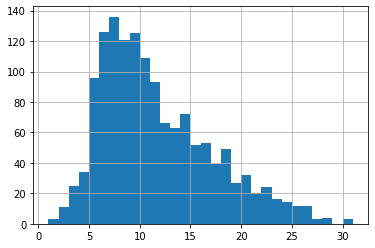

In [7]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [8]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 140,
    pad_to_max_length=True,
    truncation=True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 140,
    pad_to_max_length=True,
    truncation=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 140,
    pad_to_max_length=True,
    truncation=True
)

/opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2198: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [9]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [10]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 8

train_data = TensorDataset(train_seq, train_mask, train_y)

train_sampler = RandomSampler(train_data)

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)

val_sampler = SequentialSampler(val_data)

val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [11]:
for param in model1.parameters():
    param.requires_grad = False

In [12]:
for param in model2.parameters():
    param.requires_grad = False

In [13]:
# class BERT_Arch(nn.Module):

#     def __init__(self, bert):
      
#       super(BERT_Arch, self).__init__()

#       self.bert = bert 
      
#       self.dropout = nn.Dropout(0.1)
      
#       self.relu =  nn.ReLU()

#       self.fc1 = nn.Linear(768,512)
     
#       self.fc2 = nn.Linear(512,2)

#       self.softmax = nn.LogSoftmax(dim=1)

   
#     def forward(self, sent_id, mask):
#       #print(sent_id)
#       #print(mask)
 
#       _, cls_hs = self.bert(sent_id, mask)[:2]
      
#       x = self.fc1(cls_hs)

#       x = self.relu(x)

#       x = self.dropout(x)

#       x = self.fc2(x)
      
#       x = self.softmax(x)
#       print(x)

#       return x

In [14]:
# class ROBERT_Arch(nn.Module):

#     def __init__(self, robert):
      
#       super(ROBERT_Arch, self).__init__()

#       self.robert = robert 
      
#       self.dropout = nn.Dropout(0.1)
      
#       self.relu =  nn.ReLU()

     
#       self.fc1 = nn.Linear(768,2)
      
#       #self.fc2 = nn.Linear(512,2)

#       #self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self, sent_id, mask):
 
#       _, cls_hs = self.robert(sent_id, mask)[:2]
      
#       x = self.fc1(cls_hs)

#       x = self.relu(x)

#       #x = self.dropout(x)

#       #x = self.fc2(x)

# #       x = self.softmax(x)
#       print(x.shape)
#       return x

In [15]:
# model2 = BERT_Arch(model2)

# model2 = model2.to(device)

In [16]:
# model1 = ROBERT_Arch(model1)

# model1 = model1.to(device)

In [17]:
print(model1)

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

In [18]:
class Ensemble(nn.Module):

    def __init__(self, model1, model2):
      
      super(Ensemble, self).__init__()

      self.model1 = model1
    
      self.model2 = model2
      
      self.dropout = nn.Dropout(0.1)
      
      self.relu =  nn.ReLU()

     
      self.fc1 = nn.Linear(768,512)
      
      self.fc2 = nn.Linear(512,2)

      self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
 
      _, cls_hs1 = self.model1(sent_id, mask)[:2]
      
      #print('----------------------------------------------')
    
      _, cls_hs2 = self.model2(sent_id, mask)[:2]
      
      #print(cls_hs1.shape)
      #print(cls_hs2.shape)
        #cls_hs = np.mean(np.array([cls_hs1,cls_hs2]),axis=0)
      #cls_hs = cls_hs1.add(cls_hs2)
      #cls_hs = torch.mean(cls_hs)
      cls_hs = (cls_hs1 + cls_hs2) / 2
      #print(cls_hs)
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      x = self.fc2(x)

      x = self.softmax(x)

      return x

In [19]:
ensemble = Ensemble(model1,model2)

In [20]:
ensemble = ensemble.to(device)

In [21]:
from transformers import AdamW

optimizer = AdamW(model1.parameters(),
                  lr = 1e-5) 

In [22]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [1. 1.]


/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=1036    1
1006    1
1672    1
90      0
107     0
       ..
932     1
1029    1
854     0
914     1
1547    1
Name: label, Length: 1440, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [23]:
weights= torch.tensor(class_weights,dtype=torch.float)

weights = weights.to(device)

cross_entropy  = nn.NLLLoss(weight=weights) 

epochs = 10

In [24]:
def train():
  
  ensemble.train()

  total_loss, total_accuracy = 0, 0
  
  total_preds=[]
 
  for step,batch in enumerate(train_dataloader):
    
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch
    #print(sent_id)
#     sent_id = sent_id + 0.0001
#     mask = mask + 0.0001
    #print(mask)
    #print(mask * sent_id)
    
   
    ensemble.zero_grad()        

    preds = ensemble(sent_id, mask)
    print(preds)

    loss = cross_entropy(preds, labels)

    total_loss = total_loss + loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(ensemble.parameters(), 1.0)

    optimizer.step()

    preds=preds.detach().cpu().numpy()

    total_preds.append(preds)

  avg_loss = total_loss / len(train_dataloader)
  
  total_preds  = np.concatenate(total_preds, axis=0)

  
  return avg_loss, total_preds

In [25]:
def evaluate():
  
  print("\nEvaluating...")
 
  ensemble.eval()

  total_loss, total_accuracy = 0, 0
  
  total_preds = []

  for step,batch in enumerate(val_dataloader):
    

    if step % 50 == 0 and not step == 0:
      
            
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch
    
    
    with torch.no_grad():
     
      preds = ensemble(sent_id, mask)

      
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  
  avg_loss = total_loss / len(val_dataloader) 

 
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [26]:
best_valid_loss = float('inf')

train_losses=[]
valid_losses=[]

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    

    train_loss, _ = train()
    
   
    valid_loss, _ = evaluate()
    
   
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(ensemble.state_dict(), 'saved_weights.pt')
    

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 50
  Batch    50  of    180.
  Batch   100  of    180.
  Batch   150  of    180.

Evaluating...

Training Loss: 0.698
Validation Loss: 0.698

 Epoch 2 / 50
  Batch    50  of    180.
  Batch   100  of    180.
  Batch   150  of    180.

Evaluating...

Training Loss: 0.699
Validation Loss: 0.698

 Epoch 3 / 50
  Batch    50  of    180.
  Batch   100  of    180.
  Batch   150  of    180.

Evaluating...

Training Loss: 0.698
Validation Loss: 0.698

 Epoch 4 / 50
  Batch    50  of    180.
  Batch   100  of    180.
  Batch   150  of    180.

Evaluating...

Training Loss: 0.698
Validation Loss: 0.698

 Epoch 5 / 50
  Batch    50  of    180.
  Batch   100  of    180.
  Batch   150  of    180.

Evaluating...

Training Loss: 0.699
Validation Loss: 0.698

 Epoch 6 / 50
  Batch    50  of    180.
  Batch   100  of    180.
  Batch   150  of    180.

Evaluating...

Training Loss: 0.699
Validation Loss: 0.698

 Epoch 7 / 50
  Batch    50  of    180.
  Batch   100  of    180.
  Batch   150  

In [27]:
with torch.no_grad():
  preds = ensemble(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [28]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        90
           1       0.00      0.00      0.00        90

    accuracy                           0.50       180
   macro avg       0.25      0.50      0.33       180
weighted avg       0.25      0.50      0.33       180



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)

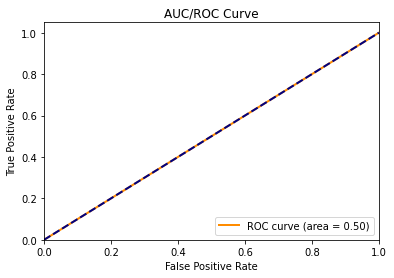

In [30]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC/ROC Curve')
plt.legend(loc="lower right")
plt.show()